### Import Packages

In [20]:
import glob  # OS dependencies to get file system details

#importing some useful packages
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

### Read list of images with different colour channels

In [21]:
def show_images(images, gray=None):
    """
    This is an utility function to show multiple images with different colour maps

    :param images - An images list
    :param gray - A flag to set default value for matplotlib imshow colour map. If the image
                  shape is 2( i.e binary image) then cmap value will be "gray"
    :return: Nothing
    """
    rows = (len(images)+1)//2
    plt.figure(figsize=(10, 11))
    for idx, img in enumerate(images):
        plt.subplot(rows, 2, idx+1)
        # if the image is binary then it'll be printed as grayscale, otherwise colour map
        # will be ignored
        plt.imshow(img, cmap="gray" if len(img.shape) == 2 else gray)
        plt.xticks([])
        plt.yticks([])

    plt.show()


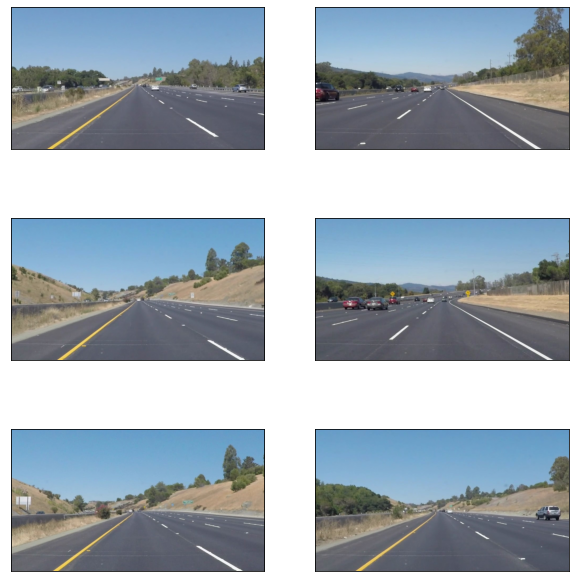

In [22]:
# Load images from test_image directory
test_images = [plt.imread(path) for path in glob.glob("test_images/*")]
# Visualize images
show_images(test_images)

### Helper Functions
#### Grayscale images using OpenCV

In [23]:
def grayscale(img):
    """
    Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')

    :param img - Input image
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### Visualize sample gray scaled test images

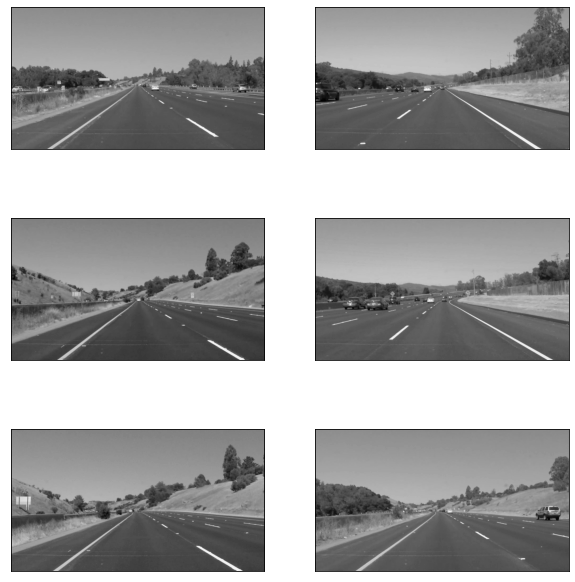

In [24]:
# Apply OpenCV grayscale function for test images
images_grays = [grayscale(img) for img in test_images]
show_images(images_grays)

#### Blur images using Gaussian blur

In [25]:
def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    :param img -
    :param kernel_size -

    :return  - a blur image
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#### Applying Guassian blur filter for gray scaled images

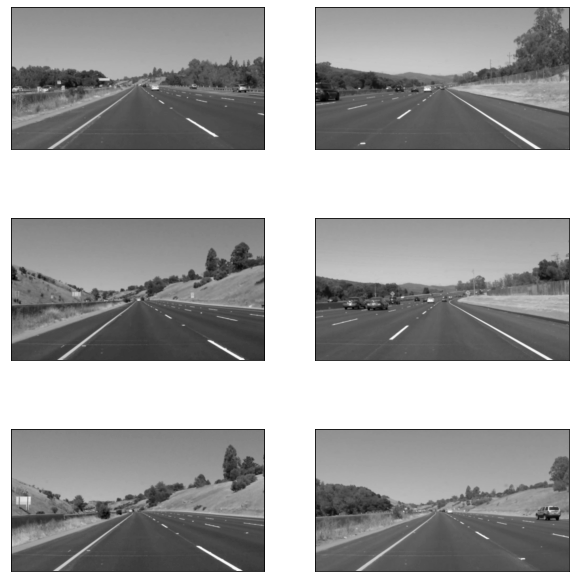

In [26]:
# define a kernel size
kernel_size = 5
# apply blur filter for gray scaled images
blur_images = [gaussian_blur(img, kernel_size) for img in images_grays]
# visualize blur images
show_images(blur_images) # colour channel not changed

In [27]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

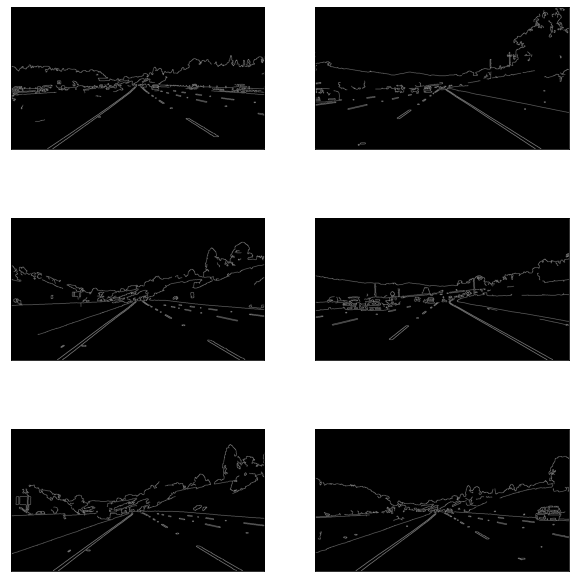

In [28]:
low_threshold = 50
high_threshold = 150

edges_images = [canny(img, low_threshold, high_threshold) for img in blur_images]
show_images(edges_images)

#### Select interest regions

In [29]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    :param img - input image to select interest region
    :param vertices - interested region vertices
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [30]:
def get_vertices(img):
    test_blur_img = img
    imshape = test_blur_img.shape
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    return vertices

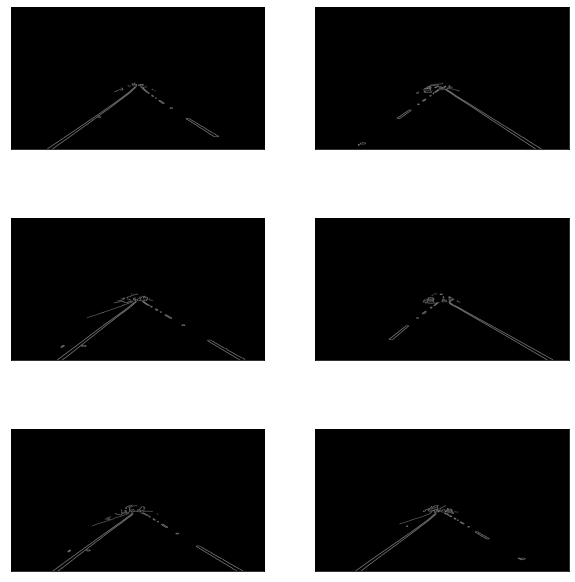

In [31]:
masked_images = [region_of_interest(img, get_vertices(img)) for img in edges_images]
show_images(masked_images)

In [32]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [33]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1# maximum gap in pixels between connectable line segments

In [34]:
def process_image(masked_img):
    return hough_lines(masked_img, rho, theta, threshold,min_line_length, max_line_gap)


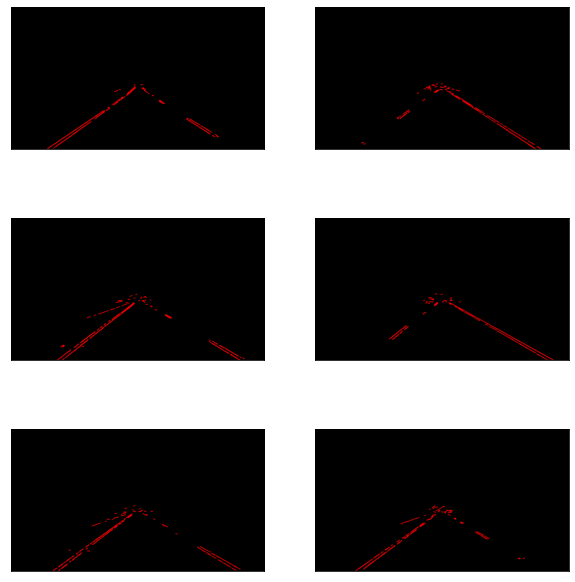

In [35]:
images = [process_image(img) for img in masked_images]
show_images(images)

In [36]:
def color_binary_image(edges):
    return np.dstack((edges, edges, edges))

In [37]:
def create_line_image(img):
    return np.copy(img)


In [38]:
line_edges_image = [weighted_img(color_binary_image(edges),create_line_image(test_images[i])) for i, edges in enumerate(images)]
show_images(line_edges_image)

error: OpenCV(4.4.0) /tmp/pip-req-build-qacpj5ci/opencv/modules/core/src/arithm.cpp:666: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


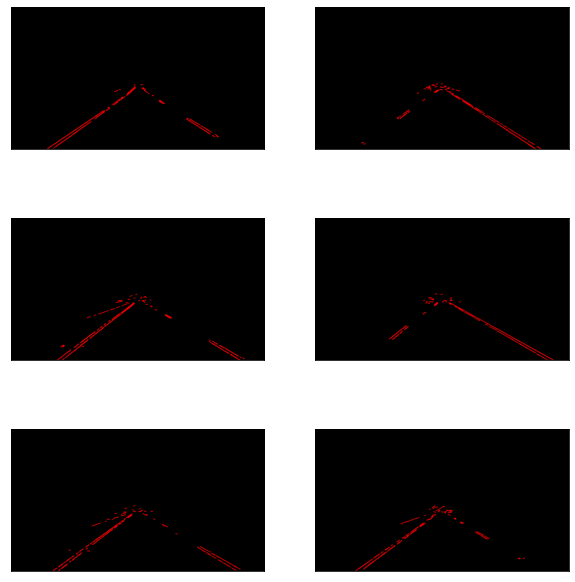

In [19]:
images = [process_image(img) for img in masked_images]
show_images(images)